### Sign in
* To get the data.

In [1]:
%%capture
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/aiLSyjqicj0bNleEXXbT2o6UV9bRTEHccR3uG6Gx3ZE
API Key valid
Gitlab access token valid
Saved details successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c htrec-2022 -o data

official_ranking.csv:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

original_test.csv:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

synthetic_test.csv:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/45.5k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/395k [00:00<?, ?B/s]

In [4]:
%%capture
!pip install pywer
import pywer
import pandas as pd
import numpy as np
import os

In [5]:
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
print(f"{train_df.shape[0]} train and {test_df.shape[0]} instances"); train_df.sample()

1875 train and 338 instances


,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM
827,κτισεως αρσεν και θηλυ ε,κτισως ἀἈρσεν και λως,13,59 Bodleian-Library-MS-Barocci-31_00319_fol-15...,16


# Preprosessing

In [7]:
ht_raw = " ".join(train_df.HUMAN_TRANSCRIPTION.to_list())
st_raw = " ".join(train_df.SYSTEM_TRANSCRIPTION.to_list())
print(f"{len(set(ht_raw.lower()))} characters in human transcription")
print(f"{len(set(st_raw.lower()))} characters in system transcription")
print(f"The following characters have not been system-transcribed: \n{set(ht_raw.lower())-set(st_raw.lower())}")
print(f"The following *have been* system-transcribed: \n{set(ht_raw.lower()).intersection(set(st_raw.lower()))}")

131 characters in human transcription
77 characters in system transcription
The following characters have not been system-transcribed: 
{'ϊ', 'ῤ', 'ΐ', 'ῇ', 'ἥ', 'ώ', 'ᾦ', 'ῄ', 'ὧ', 'ὦ', '΄', 'ὓ', 'ἧ', 'ύ', 'ἃ', 'ἇ', ';', 'ὤ', 'ᾑ', 'ἷ', "'", 'ἄ', 'ᾴ', 'ὖ', ';', 'ἦ', 'ὠ', 'ὃ', 'ᾄ', 'ὣ', 'ᾅ', 'ί', 'ή', 'ά', 'ὀ', 'ᾠ', 'ἅ', 'ᾧ', 'ᾗ', 'ὔ', 'ὄ', 'ὗ', 'ἂ', 'ἳ', 'ᾤ', 'έ', 'ᾔ', 'ὕ', 'ῒ', 'ᾷ', 'ᾶ', '᾿', 'ἣ', 'ῥ'}
The following *have been* system-transcribed: 
{'ὲ', 'α', 'ν', 'ὢ', 'φ', 'ῴ', 'ῷ', 'θ', 'ὑ', 'ι', 'ε', 'ῆ', 'ὺ', 'ῖ', 'ἀ', '·', 'ξ', 'η', 'ό', 'ύ', 'ἁ', 'ὶ', 'υ', 'λ', 'ρ', 'ἡ', 'ἐ', 'ᾳ', 'ο', 'ς', 'ῳ', 'ἤ', 'ὡ', 'ω', 'ἑ', 'ψ', 'ὴ', 'ῦ', 'ώ', 'γ', 'ἱ', 'ἕ', 'ζ', 'ῶ', 'δ', 'σ', 'έ', 'ὅ', 'ἵ', 'ἢ', 'ά', 'π', 'ῃ', 'ἶ', 'ό', 'ὐ', 'ί', 'ἠ', 'ὸ', 'ή', 'κ', 'ἰ', 'ἴ', 'ἔ', 'μ', ',', ' ', '.', '·', 'ὁ', 'τ', '᾽', 'β', 'ὰ', 'ὼ', 'χ', 'ὥ'}


In [8]:
tokens = ht_raw.split()
WORDS = set(tokens) # set include unique values

In [9]:
print(f"Number of strings: {len(tokens)}")
print(f"Number of unique strings: {len(set(tokens))}")

Number of strings: 12797
Number of unique strings: 6210


# Models

### B1: Edit-distance-based baseline

In [10]:
def eddi(input_text, reference_words=WORDS, ed_threshold=25, max_unk_tokens=3):
  """ Baseline I: Edit distance -based Baseline
  An edit distance-based baseline: Given a list of valid (reference) words,
  this baseline (called eddi) detects words not in the reference list and 
  changes them to the closest one in the reference list.
  :param input_text: the source text
  :param reference_words: a list of valid words (e.g., computed from the target data) 
  :param ed_threshold: the edit distance threshold below from which a word is replaced
  :param max_unk_tokens: the max number of unknown tokens in the transcribed text 
  :return: the new text
  """
  tokens = input_text.split()
  # Unknown transcribed tokens; proceed only if few
  unknowns = [i for i, w in enumerate(tokens) if w not in reference_words]
  if len(unknowns) > max_unk_tokens:
    return " ".join(tokens)

  for ind in unknowns:
    # Replace each uknown token with the ground truth token w/min edit distance 
    word = tokens[ind]
    min_cer, new_word = 100, word
    for ref in reference_words:
      candidate_min_cer = pywer.cer([ref], [word])
      if candidate_min_cer < min_cer:
        min_cer = candidate_min_cer
        if min_cer < ed_threshold:
          new_word = ref
    tokens[ind] = new_word
  return " ".join(tokens)

In [11]:
# Predict for training set
train_df["B1"] = train_df.SYSTEM_TRANSCRIPTION.apply(eddi)

In [12]:
# Calculate CER for baseline predictions
train_df["B1_CER"] = train_df.apply(lambda row: pywer.cer([row.HUMAN_TRANSCRIPTION], [row.B1]), axis=1)
print(f"B1 CER: {train_df.B1_CER.mean()}")

# Computing the character error *reduction* rate (CERR)
train_df["CER"] = train_df.apply(lambda row: pywer.cer([row.HUMAN_TRANSCRIPTION], [row.SYSTEM_TRANSCRIPTION]), axis=1)
print(f"B1 CERR: {(train_df.CER - train_df.B1_CER).mean()}")

B1 CER: 33.932947307411425
B1 CERR: 0.3221276698811715


In [14]:
# Use B1 to predict for the test
test_df["B1"] = test_df.SYSTEM_TRANSCRIPTION.apply(eddi)
test_df.sample()

,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM,B1
33,ώδὲ προς δοκήήσαι σκκἀνοητ ἐκεν,14,101 Bodleian-Library-MS-Barocci-127_00166_fol-...,15,ώδὲ προς δοκήήσαι σκκἀνοητ ἐκεν


### B2: LM-based Baseline


Use a word-based statistical language model to replace any unknown system-transcribed words. 

In [15]:
# LMing -based baseline
!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM
wlm = LM(gram="WORD").train(tokens)
wlm.generate_text()

fatal: destination path 'lm' already exists and is not an empty directory.


'ἐγγινομένα πάθη μὴ σβεννύντες ἀλλὰ τῆ εκλύσει τοῦ βίου τοῦ καθ ΄ εαυτοὺς πολλὰ γίνεσθαι συγχωροῦν τες ἐμπυρίζουσι τὸν ἀμπελῶνα ἀλλὰ καὶ ὁ διὰ τῆς ἡδεῖας πλεονεξίας πολλοὺς εἰς τὴν τῶν ἀλλ οτρίων ἐπιθυμίαν προκαλούμενος ἐμπυρί ζει τὸν ἀμπελῶνα επισυνάπτει γοῦν τό καὶ ἡ ἀρπα γὴ τοῦ πτωχοῦ ἐν τοῖς οἴκοις ὑμῶν ἐὰν τὰ εἰς λόγον τῆς ἀναπαύσεως τῶν πενήτων διδόμενα ἐν τοῖς οἴκοις ἔχωμεν ἀποστεροῦντες τοὺς ἐνδεεῖς τι υμεις αδικειτε τον λαο μου και το προσωπον των πτωχων καταισχυνετε εθος τοις αδικουσι και αποστερουσιν επειδαν εγκαλωνται παρα των ηδικημενων υβρεσι και λοι δοριαις καταισχυνειν αυτους εξευτελιζοντες και πληγας απειλουντες και ως φιλοπραγμονας δια βαλλλοντες ου μονον ουν φησιν αδικειτε τον πενητα ευδιαρπαστον οντα και ευεπιβουλευτον δια την ερημιαν αλλα και καταισχυνετε τα προσωπα των πτωχων την υμιν προσηκουσαν εκ της α δικιας αισχυνην ταυτην εκ της τυραννιδος υμων τοις πτωχοις περιτρεπετε μαρτυρας αναπειθο ντες συνηγορους μισθουμενοι τους δικαζοντας παραπειθοντες εως αν προς τη

In [16]:
def lamo(input_text, reference_words=WORDS, lm = wlm, max_unk_tokens=2):
  """ Baseline II: LM-based Baseline
  Any unknown words in the transcribed text are replaced by word suggested by
  a language model trained on the ground truth texts.
  :param input_text: the (transcribed) text in question
  :param reference_words: the reference vocabulary
  :param lm: a word-based statistical language model
  :param max_unk_tokens: the max number of unkown words in the text 
  :return: the new text
  """
  tokens = input_text.split()
  # Unknown transcribed tokens; proceed only if few
  unknowns = [i for i, w in enumerate(tokens) if w not in reference_words]
  if len(unknowns) > max_unk_tokens:
    return " ".join(tokens)
  for ind in unknowns:
    # Replace each uknown token with the ground truth token w/min edit distance 
    new_word = wlm.generate_next_gram(tokens[:ind-1])
    tokens[ind] = new_word
  return " ".join(tokens)

In [17]:
# computing the B2 
train_df["B2"] = train_df.SYSTEM_TRANSCRIPTION.apply(lamo)

In [18]:
# computing the B2 CER
train_df["B2_CER"] = train_df.apply(lambda row: pywer.cer([row.HUMAN_TRANSCRIPTION], [row.B2]), axis=1)
print("B2's CER:", train_df.B2_CER.mean())
# computing B2's CERR
print((train_df.CER - train_df.B2_CER).mean())

B2's CER: 40.79369804149079
-6.5386230641982035


In [19]:
# Use B2 to predict for the test
test_df["B2"] = test_df.SYSTEM_TRANSCRIPTION.apply(lamo)
test_df.sample()

,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM,B1,B2
321,εαπειν πασης ουσίας κιίςδυναμεω ἐνερ,15,15th Bodleian-Library-MS-Barocci-59_00006_fol-7v,14,εαπειν πασης ουσίας κιίςδυναμεω ἐνερ,εαπειν πασης ουσίας κιίςδυναμεω ἐνερ


### B3: LMing

LMing-Rules baseline
* Using language modeling.
* Using rules, extracted from the training data.

Using the human-transcribed data to train a statistical character language model.

In [20]:
!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM
lm = LM(gram="CHAR").train(train_df.HUMAN_TRANSCRIPTION.sum()); #cslm.generate_text()
lm.generate_text()

fatal: destination path 'lm' already exists and is not an empty directory.


'ἐγγινομενον κοσμησιν,οὐνόν διά πράσσου ορωμεν ἐκείνου και ινα οψεσιτους ἀπωσάμενοι οφθαλμοὺςἔχοντες καλλιάσομαι φανερωθησομένη καταβαινέτω καθαρεύειν· ἵνααὐτὸν δὲ θανοῦς· ἡ δέ τῆς φρέατα, τὼ νεφρὼ δέ μοιχαταισιν χαίρε το φως ημεις επειδανεγκεν εκαστω αυτόκαλονσοι συγκατιουσαλὴμ, κρέας ἐλπὶς ἥ σ᾽ ἐσεῖδον; εἴργασωνται,ἢ προφητης διαφθείρῃς, τὴν γέενναν ετεροςδημιουργηθεν δευτελιζοντα τους σωθηναι εδεικνυμεν και το τη περιγραφη λόγος·ιδουσι τοίνυν ὁ τοῦ, πολλαι φανείη γ᾽ αὔτ᾽ εὐσεβῆ τε πατρῴαν αυτας αὐτὸ μὲν ἤδη προφήτης κοσμου τήν ἀξιούμεθ᾽ ἥκοντ᾽ ἰδεῖν δοξαν αιγειν. Ἐπειδὴ ληματα Τῇ γὰρ ἐν τοῦΔαβὶδ γαμηθη υγεια γραφη λεξει εχρημένοι και τη ελλην επαριστον περιαυταλειψει αυτων και ἀπὸ πρᾶγμα; ἀλλὰ δείξει μου. Ἱκετεύειν ο θς αρχης σωφροσυνης λεγω καὶ Συρίαπάσχουσιν υποδημασιν ὁ τοῦ λόγος ειπεν αὐτοὺς ὑπέρἡμῶν.Ταῦτα ὑπομενοιτην γνῶσιν φράσαι τ αλλα κινουμεν αὐτῶν, καὶ ψεύδους θείῳ τοὺς πόλιν, καί τοις ὄνοματικῶς ἀπειλάς; οὐ κοιλάδατῶνἄδυτον ου μνηστευομεν σαυτη ακολουθῶν τὸν Ἱπποκίνου ημι

#### Frequently mistaken tokens 

In [21]:
LEX = train_df.HUMAN_TRANSCRIPTION.sum().split()

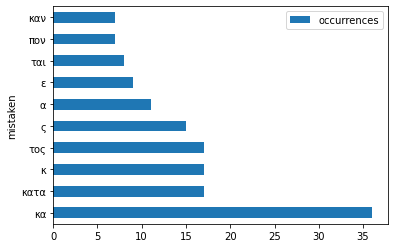

In [22]:
from collections import Counter
broken_words = [w for w in train_df.SYSTEM_TRANSCRIPTION.sum().split() if w not in set(LEX)]
x,y = zip(*Counter(broken_words).most_common(10))
pd.DataFrame({"mistaken":x, "occurrences":y}).plot.barh(x="mistaken");

Picking one, one that can be fixed without much ambiguity.

In [23]:
train_df[train_df.SYSTEM_TRANSCRIPTION.str.contains(" ς ")].sample(2)

,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM,B1,B1_CER,CER,B2,B2_CER
928,τούτοις αὐδῶ καὖθις ἐπαυδῶ καὖθις τὸ τρίτον μά...,κεπτουδτοι ς α παυδυ καυθις επαυ κανε τριμαλα,14,65 Bodleian-Library-MS-Barocci-127_00135_fol-6...,1,κεπτουδτοι ς α παυδυ καυθις επαυ κανε τριμαλα,63.636364,63.636364,κεπτουδτοι ς α παυδυ καυθις επαυ κανε τριμαλα,63.636364
1178,"τοῦ Θῦ γίνεται Λόγος, ὡς ζωή νεκροῖς",τοῦ δυσιν εσαιλόγος ς ξωην ἐκρ,15,78 Bodleian-Library-MS-Barocci-59_00083_fol-46...,8,τοῦ δυσιν εσαιλόγος ς ξωην ἐκρ,52.777778,52.777778,τοῦ δυσιν εσαιλόγος ς ξωην ἐκρ,52.777778


#### The method
Exploring the mistakes, two are the easier fixes: merge with the previous word (i.e., this is a final character, which makes sense) or delete. To pick out of the two, we ask the LM.

In [24]:
def lmr(text, word=" ς ", replacements=["ς ", " "], lm=lm):
    scores = []
    for the_candidate in replacements:
        scores.append(lm.cross_entropy(text.replace(word, the_candidate)))
    text_out = text.replace(word, replacements[scores.index(min(scores))])
    return text_out
    
lmr("ως ω ς αὐτοῦ ον πος τοῦ χυ καιρήε,")

'ως ως αὐτοῦ ον πος τοῦ χυ καιρήε,'

In [25]:
# computing the B3 
train_df["B3"] = train_df.SYSTEM_TRANSCRIPTION.apply(lmr)

# computing the B3 
test_df["B3"] = test_df.SYSTEM_TRANSCRIPTION.apply(lmr)

In [26]:
# computing the B3 CER
train_df["B3_CER"] = train_df.apply(lambda row: pywer.cer([row.HUMAN_TRANSCRIPTION], [row.B3]), axis=1)
print("B3's CER:", train_df.B3_CER.mean())
# computing B3's CERR
print((train_df.CER - train_df.B3_CER).mean())

B3's CER: 34.244597148838
0.01047782845459524


# Generating the Prediction File

In [42]:
# using the 1st baseline (B1)
submission = pd.DataFrame(zip(test_df.IMAGE_PATH, test_df.B1), columns=["ImageID", "Transcriptions"])
submission.to_csv('B1_edit_distance.csv',index=False)

In [43]:
# using the 2st baseline (B2)
submission = pd.DataFrame(zip(test_df.IMAGE_PATH, test_df.B2), columns=["ImageID", "Transcriptions"])
submission.to_csv('B2_LM_based.csv',index=False)

In [44]:
# using the 3st baseline (B3)
submission = pd.DataFrame(zip(test_df.IMAGE_PATH, test_df.B3), columns=["ImageID", "Transcriptions"])
submission.to_csv('B3_LMing.csv',index=False)
submission.head()

,ImageID,Transcriptions
0,66 Bodleian-Library-MS-Barocci-127_00136_fol-66v,ὑπρ τη συνευςδιξοεανδνυπορ ποοδυπρας
1,66 Bodleian-Library-MS-Barocci-127_00136_fol-66v,ἢ μητακχεφιλοχορ εύτα δυ μπρο πρενπεμε
2,66 Bodleian-Library-MS-Barocci-127_00136_fol-66v,συ σ κατεχισωμε ἐπιτελωτι
3,66 Bodleian-Library-MS-Barocci-127_00136_fol-66v,κ ἀπαὐτελετία τὸν δεὲ τὸν σανἀαλισκόν
4,66 Bodleian-Library-MS-Barocci-127_00136_fol-66v,κ τὸρακον καξεύδὡςτα ξήμής παιξτεεχηρευ


In [29]:
submission.to_csv("submission.csv", index=False)

In [ ]:
# %aicrowd submission create -c htrec-2022 -f submission.csv